In [1]:
import torch, torchvision
import matplotlib.pyplot as plt
import kornia
import cv2
import tqdm
import numpy as np
import einops
import timm
import numpy as np
from PIL import Image
import random
from kornia import tensor_to_image as t2i



with open("imagenet1000_clsidx_to_labels.txt", 'r') as labels_file:
    labels = labels_file.read().splitlines()


    
def max_contrast(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor


In [2]:


models = [
    'resnet50', 
    'vit_base_patch16_224', 
    'tf_efficientnet_b0_ap', 
    'adv_inception_v3', 
    'inception_v4',
    'densenet121',
    'mobilenetv3_large_100',
    'resnext101_32x8d',
    'seresnet152d',
    'ig_resnext101_32x16d',
    'nf_resnet50',

]

network_dicts = [ {'name': name, 'net': timm.create_model(name, pretrained=True)} for name in models]



for net_dict in network_dicts:
    net = net_dict['net'].eval()
    for param in net.parameters():
        param.requires_grad = False
  



In [3]:

rotate = True
resized_crop = True
jitter = False
flip = False
H, W = 512, 512


input_tensor = torch.distributions.Normal(0.0, 0.1).sample([3, H, W]).cuda()
input_tensor.requires_grad=True

batch_transforms = torch.nn.Sequential(
    
    
    kornia.augmentation.RandomAffine(
        degrees=30,
        same_on_batch=False,
        padding_mode=1,
        p= 1 * rotate,
    ),
    
    kornia.augmentation.RandomResizedCrop(
        size=(224, 224), 
        scale=(0.1, 2.0),
        ratio=(0.25, 4.0), #aspect ratio
        p= 1 * resized_crop,

    ),


    kornia.augmentation.ColorJitter(
        brightness=0.1, 
        contrast= 0.1, 
        saturation= 0.1, 
        hue= 0.1, 
        same_on_batch=False,
        p=1. * jitter,
    ),

    
    kornia.augmentation.RandomHorizontalFlip(
        p = 0.5 * flip,
    ),

    
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
                                       
)



In [4]:
max_list = []
grads_max_list = []
img_grads_max_list = []
activations = []
images = []
grad_images = []

TARGET_CLASSES = [388]

for target_class in TARGET_CLASSES:
    print(labels[target_class])

optimizer = torch.optim.Adam([input_tensor], lr=0.025)

 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',


100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


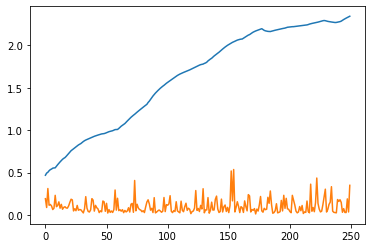

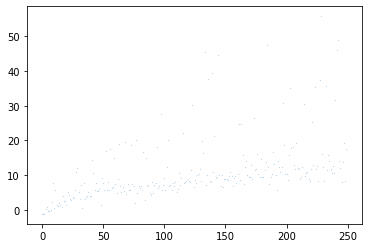

In [5]:
ITERATIONS = 250
BATCH_SIZE = 8
TV_LOSS_COEFF = 0


for n in tqdm.tqdm(range(ITERATIONS)):

   
    input_img = torch.sigmoid(input_tensor)  
    input_img.retain_grad()

    net_dict = random.choice(network_dicts)
    net = net_dict['net'].cuda()
    
    input_img_batch = einops.repeat(input_img, 'c h w -> b c h w', b = BATCH_SIZE)
    transformed_input_img_batch = batch_transforms(input_img_batch)

    
    out = net(transformed_input_img_batch)
    target = out[:, TARGET_CLASSES].mean()
    activations.append(target.item())


    tv_loss = kornia.losses.total_variation(input_img) / torch.numel(input_img)
    
    
    loss = tv_loss * TV_LOSS_COEFF - target
  
    loss.backward()
    
    

    
    max_list.append(abs(input_tensor.max().item()))
    
    grads_max_list.append(abs(input_tensor.grad.max().item()))
    
    if n % 5 == 0:
        images.append(np.uint8(t2i(input_img) * 255))

    optimizer.step()
    optimizer.zero_grad()
    
    
  
    
plt.figure(); 
plt.plot(max_list); 
plt.plot(grads_max_list); 
plt.show()



plt.figure()
plt.scatter(np.arange(len(activations)), activations, s=0.01)
plt.show()




11it [00:03,  3.52it/s]


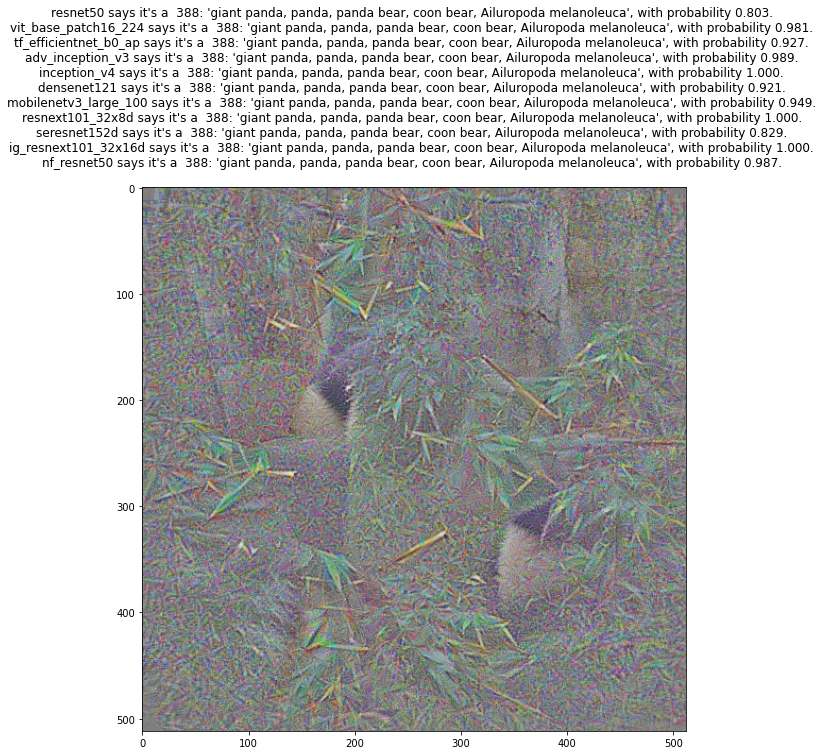

In [6]:
plt.figure(figsize=[10, 10])

plt.imshow(t2i(input_img))


title_string = ''
with torch.no_grad():
    for n, net_dict in tqdm.tqdm(enumerate(network_dicts)):
        net = net_dict['net']
        input_img_batch = einops.repeat(input_img, 'c h w -> b c h w', b = 32)
        transformed_input_img_batch = batch_transforms(input_img_batch)

        out = net(transformed_input_img_batch).mean(dim=0)
        
        out_argmax = torch.argmax(out, -1).item()
        out_probs = torch.softmax(out, -1)
        out_label = labels[out_argmax]
        out_prob  = out_probs[out_argmax].item()
        title_string += f"{net_dict['name']} says it's a {out_label} with probability {out_prob:0.3f}. \n" 
        

plt.title(title_string)
plt.show()





In [15]:
import imageio

with imageio.get_writer('vid.avi', fps=10) as writer:
    for im in images:
        writer.append_data(im)


imageio.imwrite('img.png', im)


